In [1]:
import pandas as pd
df = pd.read_csv("../Data/df_score_as_value.tsv", sep="\t", index_col=0)

In [2]:
disease = "bipolar disorder"
METHOD = "unidirectional_multilayer_rwr"
FOLDER = "BIPOLAR"
hypergraph_result_df = pd.read_csv(f"../Methods/output/DGIDB_{FOLDER}/{METHOD}_results.csv")

In [3]:
# Filter genes with a non-NaN score for bipolar disorder
filtered_df = df[df[disease].notna()]
filtered_df = filtered_df.sort_values(by=disease, ascending=False)
# Optional: print the resulting gene names and scores
print(filtered_df[disease].head(10))


geneCommonName
SCN2A      0.727275
DRD2       0.685297
GSK3B      0.625937
HTR2A      0.613610
HTR2C      0.611434
DRD3       0.609894
DRD4       0.608982
SCN8A      0.607630
ALDH5A1    0.607372
IMPA1      0.607121
Name: bipolar disorder, dtype: float64


In [24]:
# Normalize scores in filtered_df
filtered_df["normalized_score"] = filtered_df[disease] / (filtered_df[disease].sum())
filtered_df["normalized_score"]

geneCommonName
BRCA2     0.001406
BRCA1     0.001377
CHEK2     0.001344
PALB2     0.001303
PIK3CA    0.001226
            ...   
NPSR1     0.000002
NPRL3     0.000002
NPPC      0.000002
RNU2-1    0.000002
GNL2      0.000002
Name: normalized_score, Length: 13970, dtype: float64

In [25]:
print(hypergraph_result_df)

       Index     Score  ncbi_gene_id claim_name     Linked
0      13090  0.037095          5290     PIK3CA  Biomarker
1      17490  0.033613          7157       TP53  Biomarker
2      15579  0.020103           595      CCND1  Biomarker
3      10310  0.014310          3845       KRAS  Biomarker
4      15588  0.012995           596       BCL2  Biomarker
...      ...       ...           ...        ...        ...
21976  17743  0.000039        729494    ARPC3P3        NaN
21977  17754  0.000039        729646    RPL31P4        NaN
21978  17793  0.000039        730138     PFN1P1        NaN
21979  17796  0.000039        730222     TUBA5P        NaN
21980  20316  0.000039         86123    YWHAZP5        NaN

[21981 rows x 5 columns]


In [26]:
top50_opentargets = filtered_df.sort_values("normalized_score", ascending=False).head(10)["normalized_score"].index.tolist()
top50_hypergraph = hypergraph_result_df["claim_name"].head(10).tolist()
print(top50_hypergraph)

['PIK3CA', 'TP53', 'CCND1', 'KRAS', 'BCL2', 'HRAS', 'BAX', 'TYMS', 'BRCA1', 'CDKN1B']


In [27]:
# Set-based comparisons
overlap = set(top50_hypergraph).intersection(top50_opentargets)
only_in_hypergraph = set(top50_hypergraph) - set(top50_opentargets)
only_in_bipolar = set(top50_opentargets) - set(top50_hypergraph)

print("✅ Genes in both (overlap):", sorted(overlap))
print("\n🔹 Genes only in hypergraph_result_df top 50:", sorted(only_in_hypergraph))
print("\n🔸 Genes only in " + disease + " top 50:", sorted(only_in_bipolar))


✅ Genes in both (overlap): ['BRCA1', 'PIK3CA', 'TP53']

🔹 Genes only in hypergraph_result_df top 50: ['BAX', 'BCL2', 'CCND1', 'CDKN1B', 'HRAS', 'KRAS', 'TYMS']

🔸 Genes only in breast cancer top 50: ['ATM', 'BRCA2', 'BRIP1', 'CHEK2', 'ERBB2', 'ESR1', 'PALB2']


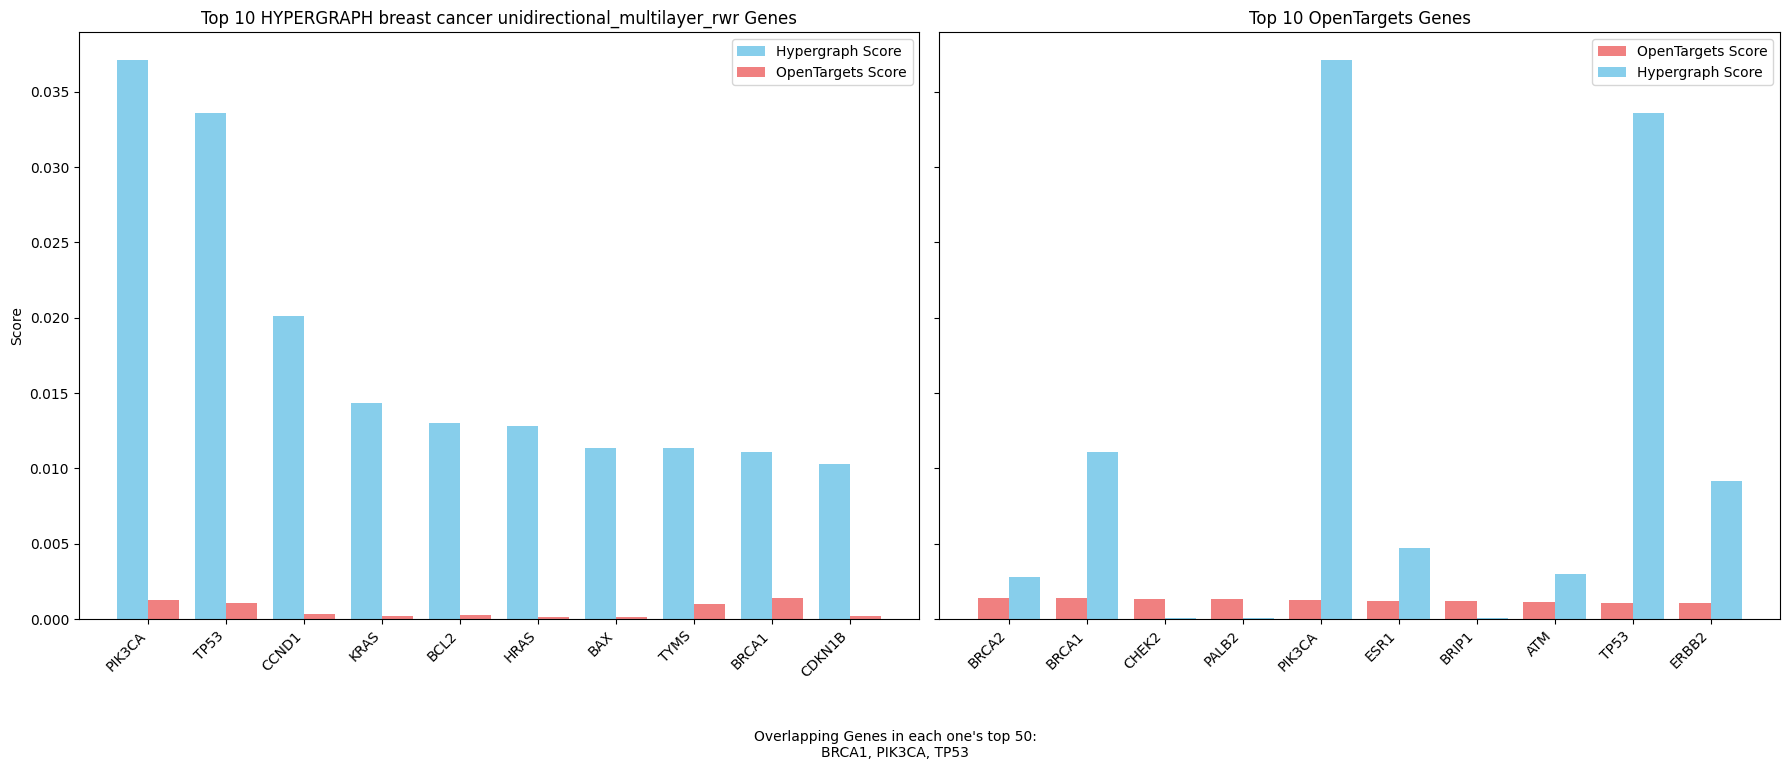

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Convert to sorted list (optional)
overlap = sorted(list(overlap))

# Join them into a single text string
overlap_text = "Overlapping Genes in each one's top 50:\n" + ", ".join(overlap)
# Assume you already have filtered_df and hypergraph_result_df

# 1. Prepare top 10 from hypergraph_result_df
top10_hypergraph = hypergraph_result_df.sort_values('Score', ascending=False).head(10)
top10_hypergraph_genes = top10_hypergraph['claim_name'].values
top10_hypergraph_scores = top10_hypergraph['Score'].values

# Get matching scores from filtered_df
top10_hypergraph_filtered_scores = filtered_df.reindex(top10_hypergraph_genes)['normalized_score'].fillna(0).values

# 2. Prepare top 10 from filtered_df
# 2. Prepare top 10 from filtered_df
top10_filtered = filtered_df.sort_values(by='normalized_score', ascending=False).head(10)
top10_filtered_genes = top10_filtered.index.values
top10_filtered_scores = top10_filtered['normalized_score'].values


# Get matching scores from hypergraph_result_df
# Create a quick lookup dictionary
hypergraph_score_dict = dict(zip(hypergraph_result_df['claim_name'], hypergraph_result_df['Score']))
top10_filtered_hypergraph_scores = [hypergraph_score_dict.get(gene, 0) for gene in top10_filtered_genes]

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Plot 1: Top 10 Hypergraph
x = np.arange(len(top10_hypergraph_genes))
width = 0.4

axes[0].bar(x - width/2, top10_hypergraph_scores, width, label='Hypergraph Score', color='skyblue')
axes[0].bar(x + width/2, top10_hypergraph_filtered_scores, width, label='OpenTargets Score', color='lightcoral')

axes[0].set_xticks(x)
axes[0].set_xticklabels(top10_hypergraph_genes, rotation=45, ha='right')
axes[0].set_title('Top 10 HYPERGRAPH '+ disease +" " + METHOD + ' Genes')
axes[0].legend()
axes[0].set_ylabel('Score')

# Plot 2: Top 10 Filtered DF
x2 = np.arange(len(top10_filtered_genes))

axes[1].bar(x2 - width/2, top10_filtered_scores, width, label='OpenTargets Score', color='lightcoral')
axes[1].bar(x2 + width/2, top10_filtered_hypergraph_scores, width, label='Hypergraph Score', color='skyblue')

axes[1].set_xticks(x2)
axes[1].set_xticklabels(top10_filtered_genes, rotation=45, ha='right')
axes[1].set_title('Top 10 OpenTargets Genes')
axes[1].legend()
fig.text(0.5, -0.05, overlap_text, ha='center', va='top', fontsize=10, wrap=True)

plt.tight_layout()
plt.show()


In [29]:
import pandas as pd
df = pd.read_csv("../Data/df_score_as_value.tsv", sep="\t")
print(df.head())

KeyboardInterrupt: 

In [ ]:
def get_diseases_for_gene(gene_name):
    try:
        matching_rows = df[df['geneCommonName'] == gene_name]
        if matching_rows.empty:
            return f"Gene '{gene_name}' not found."
        
        results = []
        
        # Loop over each matching row
        for idx, row in matching_rows.iterrows():
            row_data = row.drop(labels='geneCommonName').dropna()
            
            # Convert to numeric if possible
            try:
                row_data = pd.to_numeric(row_data)
                # row_data = row_data.sort_values(ascending=False)
            except:
                # If cannot convert, skip sorting
                pass
            
            top_diseases = list(zip(row_data.index, row_data.values))
            return top_diseases
        
        return results

    except Exception as e:
        return f"Error: {e}"


# Example usage
results = get_diseases_for_gene("DRD2")
print(results)
# for disease, score in results:
#    print(f"{disease}: {score}")

[('22q11.2 deletion syndrome', 0.0293009068458276), ('46 XX gonadal dysgenesis', 0.0733104853643487), ('46,XX ovotesticular disorder of sex development', 0.0334839348344339), ('46,XX sex reversal 1', 0.0392937301500774), ('46,XX testicular disorder of sex development', 0.0378893267022756), ('46,XY complete gonadal dysgenesis', 0.0465448868989913), ('46,XY gonadal dysgenesis-motor and sensory neuropathy syndrome', 0.0484334399564301), ('46,XY partial gonadal dysgenesis', 0.0468922919623949), ('46,XY sex reversal 1', 0.0473764415720319), ('46,XY sex reversal 11', 0.0592325633103171), ('46,XY sex reversal 3', 0.0464340129425859), ('ACTH-dependent Cushing syndrome', 0.0739159709369403), ('ACTH-producing pituitary gland adenoma', 0.0059243524998524), ('AIDS', 0.0014783194187388), ('ANE syndrome', 0.0491605883205223), ('Alzheimer disease', 0.4159282355698095), ('Asperger syndrome', 0.3020473491267322), ('BDV syndrome', 0.0306973027301113), ('BH4-deficient hyperphenylalaninemia A', 0.03411222

In [ ]:
def parse_communities(file_path):
    communities = []
    
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # skip empty lines
            
            if ':' in line:
                _, genes_part = line.split(':', 1)
                genes = [gene.strip() for gene in genes_part.split(',') if gene.strip()]
                communities.append(genes)
    
    return communities

communities = parse_communities("../Data/communities.txt")
print(communities)

[['7SK', 'AADACL3', 'ABCA6', 'ABCB9', 'ABRAXAS1', 'ACRV1', 'ADAM33', 'ADAT1', 'ADGRB2', 'ADGRB3-DT', 'AGBL3', 'AGR3', 'AIG1', 'AK8', 'AKAP8', 'AKR1C6P', 'ALG2', 'AMT', 'ANKHD1', 'ANKRD10', 'ANKRD18B', 'ANKRD30B', 'ANKRD36', 'ANKRD54', 'ANKS3', 'ANP32CP', 'ANXA2P2', 'AP1G2', 'AP1S1', 'AP1S3', 'APLP1', 'APOBEC3F', 'AQP10', 'ARB2A', 'ARGLU1-DT', 'ARHGAP19', 'ARHGAP44', 'ARIH2', 'ARMH3', 'ARNILA', 'ARSG', 'ASB12', 'ASB3', 'ASMTL-AS1', 'ATOH8', 'ATP11A-AS1', 'ATP23', 'ATRN', 'AWAT2', 'B3GNT6', 'B3GNT8', 'B4GALNT4', 'B4GALT7', 'BAIAP3', 'BCAN-AS2', 'BEND7', 'BICDL2', 'BLNK', 'BLTP3B', 'BLZF1', 'BORA', 'BPIFA3', 'BRINP2', 'BRME1', 'BTN2A3P', 'C10orf67', 'C10orf90', 'C11orf16', 'C11orf68', 'C16orf46', 'C19orf53', 'C1QTNF9B', 'C1R', 'C1orf131', 'C1orf220', 'C21orf58', 'C2orf66', 'C2orf92', 'C3orf18', 'C3orf52', 'C6orf118', 'C7orf33', 'C8orf44', 'C8orf74', 'C9orf50', 'CA3-AS1', 'CA5B', 'CABP5', 'CADM4', 'CAPN7', 'CASC17', 'CASC18', 'CASC20', 'CAVIN2-AS1', 'CC2D2B', 'CCDC107', 'CCDC150', 'CCDC169

In [ ]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

def sum_and_variance_diseases_for_gene_groups(genes_2d):
    # First pass: collect raw scores
    raw_results = []
    global_disease_totals = defaultdict(float)

    for gene_group in tqdm(genes_2d, desc="Gene groups"):
        disease_scores = defaultdict(list)

        for gene in tqdm(gene_group, desc="Genes in group", total=len(gene_group), leave=False):
            diseases = get_diseases_for_gene(gene)
            for disease, score in diseases:
                disease_scores[disease].append(score)

        disease_summary = []
        for disease, scores in disease_scores.items():
            total_score = sum(scores)
            var_score = np.var(scores, ddof=1) if len(scores) > 1 else 0.0
            disease_summary.append((disease, total_score, var_score))
            global_disease_totals[disease] += total_score

        raw_results.append(disease_summary)

    # Second pass: normalize each disease score by global total
    normalized_results = []
    for disease_summary in raw_results:
        normalized_summary = []
        for disease, total_score, var_score in disease_summary:
            global_total = global_disease_totals[disease]
            normalized_score = total_score / global_total if global_total > 0 else 0.0
            normalized_summary.append((disease, normalized_score, var_score))
        normalized_summary = sorted(normalized_summary, key=lambda x: -x[1])  # sort by normalized score
        normalized_results.append(normalized_summary)

    return normalized_results


summed_diseases = sum_and_variance_diseases_for_gene_groups(communities)

Gene groups: 100%|██████████| 19/19 [06:03<00:00, 19.15s/it]


In [ ]:
import csv

# Write to CSV
with open("summed_variance_diseases.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["group_index", "disease", "total_score", "variance"])
    
    for i, group in enumerate(summed_diseases):
        for disease, total_score, var_score in group:
            writer.writerow([i, disease, total_score, var_score])

print("Done writing to summed_variance_diseases.csv ✅")

Done writing to summed_variance_diseases.csv ✅


In [ ]:
import pandas as pd
import json
summed_disease_df = pd.read_csv("summed_variance_diseases2.csv", encoding="ISO-8859-1")

# Prepare the array to hold top 15 diseases per group
grouped_top_15 = []

# Group by 'group_index'
grouped = summed_disease_df.groupby("group_index")

for group_index, group_df in grouped:
    # Sort by total_score descending
    top_15 = group_df.sort_values(by="total_score", ascending=False).head(30)
    
    # Convert to list of dicts
    disease_list = top_15[["disease", "total_score", "variance"]].to_dict(orient="records")
    
    grouped_top_15.append(disease_list)

# Save to JSON
with open("top_15_diseases_per_group2.json", "w") as f:
    json.dump(grouped_top_15, f, indent=2)

print("✅ Saved to top_15_diseases_per_group2.json")

✅ Saved to top_15_diseases_per_group2.json


In [ ]:
import json

# Open and load a JSON file
with open('./top_15_diseases_per_group.json', 'r') as file:
    data = json.load(file)

# Now you can use the data as a Python dictionary or list
print(data)


[[{'disease': 'facial dysmorphism-macrocephaly-myopia-Dandy-Walker malformation syndrome', 'total_score': 1.0, 'variance': 0.0}, {'disease': 'congenital chylothorax', 'total_score': 1.0, 'variance': 0.0}, {'disease': 'congenital herpes virus infection', 'total_score': 1.0, 'variance': 0.0}, {'disease': 'classic congenital lipoid adrenal hyperplasia due to STAR deficency', 'total_score': 1.0, 'variance': 0.0}, {'disease': 'spastic paraplegia 90B, autosomal recessive', 'total_score': 1.0, 'variance': 0.0}, {'disease': 'short stature, oligodontia, dysmorphic facies, and motor delay', 'total_score': 1.0, 'variance': 0.0}, {'disease': 'non-classic congenital lipoid adrenal hyperplasia due to STAR deficency', 'total_score': 1.0, 'variance': 0.0}, {'disease': 'central hypoventilation syndrome, congenital, 2, and autonomic dysfunction', 'total_score': 1.0, 'variance': 0.0}, {'disease': 'vitamin B12-responsive methylmalonic acidemia, type cblDv2', 'total_score': 1.0, 'variance': 0.0}, {'disease

In [ ]:
# for row in data:
#     print("FIRST CATEGORY")
for item in data[1]:
    print(item['disease'])


alkaline ceramidase 3 deficiency
Goldmann-Favre syndrome
bilateral frontal polymicrogyria
neuropathy, hereditary sensory, type 2C
Leydig cell hypoplasia due to complete LH resistance
Leydig cell hypoplasia due to partial LH resistance
distal trisomy 15q
ring chromosome 12
adenomyoma of uterine corpus
bulbospinal muscular atrophy
autosomal dominant intermediate Charcot-Marie-Tooth disease with neuropathic pain
neurodevelopmental disorder with infantile epileptic spasms
obsolete goniodysgenesis
sickle cell-hemoglobin E disease syndrome
epilepsy-microcephaly-skeletal dysplasia syndrome
ataxia neuropathy spectrum
glycogen storage disease type 1 due to SLC37A4 mutation
malignant tenosynovial giant cell tumor
intellectual developmental disorder, autosomal dominant 72
intellectual disability, autosomal dominant 41
retroperitoneal neuroblastoma
TRAF7-associated heart defect-digital anomalies-facial dysmorphism-motor and speech delay syndrome
Dyggve-Melchior-Clausen syndrome, X-linked
neurodeve